# Deep Learning - Exercise 8

The aim of this exercise is to learn how to implement and utilize attention mechanisms in deep learning models, focusing
on how these techniques allow models to selectively focus on the most relevant parts of input data.

**Core Concepts**

- 🧠 Attention mechanism fundamentals and mathematical foundations
- 🔍 Types of attention mechanisms (Self-attention, Dot-product)
- 📊 Applications in natural language processing
- ⚙️ Implementation of attention-based models

We recommend reading
[this post](https://analyticsindiamag.com/a-beginners-guide-to-using-attention-layer-in-neural-networks/) for more
detailed information.


[Open in Google colab](https://colab.research.google.com/github/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_08.ipynb)
[Download from Github](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_08.ipynb)

##### Remember to set **GPU** runtime in Colab!


In [1]:
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Layer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import os

# from keract import get_activations
from keras import Input, Model
from tensorflow.keras.callbacks import Callback
import keras.backend as K
from tensorflow.keras import layers

os.environ['KERAS_ATTENTION_DEBUG'] = '1'
from attention import Attention

plt.rcParams.update({'font.size': 8})

keras.utils.set_random_seed(13)
tf.version.VERSION



2025-04-26 15:58:23.520308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745675903.533314   16922 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745675903.537142   16922 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-26 15:58:23.551192: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.18.0'

In [2]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

# 📒 What is the Attention mechanism?

- When we think about the English word **Attention**, we know that it means **directing your focus at something** and
  taking greater notice
- The Attention mechanism in Deep Learning is based off this concept of directing your focus, and it pays greater
  attention to certain factors when processing the data
  - 📌 Paying attention to important information is necessary and it can improve the performance of the model
- **Attention mechanism can help a neural network to memorize long sequences of the information**
  - 🔎 Remember the RNN and even LSTM long-context issues?
- 🔎 Can you imagine some use-cases where it can help us?

> 💡 In very simple terms the Attention mechanism makes sure that the forget mechanism of LSTM layers is not applied
> over the important pieces of information

### The process is usually computed in these few steps

![Img00](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_08_04.png?raw=true)

- Let’s say that we have an input with n sequences and output y with m sequence in a network
  - $x=[x_1, x_2, ..., x_n]$
  - $y = [y_1, y_2, ..., y_n]$
- The encoder which we are using in the network is a bidirectional LSTM network where it has a forward hidden state and
  a backward hidden state

  - Representation of the encoder state can be done by concatenation of these forward and backward states
  - $h_i = [h_i^{L2R}, h_i^{R2L}]$

- The hidden state is:
  - $s_t=f(s_{t-1}, y_{t-1}, c_t)$
- For the output word at position t, the context vector $C_t$ can be the sum of the hidden states of the input sequence
- Thus we have:

![Img02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_08_02.png?raw=true)

- Here we can see that the sum of the hidden state is weighted by the alignment scores
- 💡 We can say that ${\alpha_{t,i}}$ are the weights that are responsible for defining how much of each source’s hidden
  state should be taken into consideration for each output

- 💡 There can be various types of alignment scores according to their geometry
  - It can be either linear or in the curve geometry

### 📌 Below are some of the popular attention mechanisms:

![Img03](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_08_03.png?raw=true)

#### 💡 There are many variants of the mechanism in the wild but the basic computation process is the same

### The very common and easy to understand example is **Self-Attention Mechanism**

- When an attention mechanism is applied to the network so that it can relate to different positions of a single
  sequence and can compute the representation of the same sequence, it can be considered as self-attention

![Img01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_08_01.png?raw=true)

- Here in the image, the red color represents the word which is currently learning and the blue color is of the memory,
  and the intensity of the color represents the degree of memory activation


## ⚡ We will use Attention layer from the library first and try to solve the _Find-Max task_

- What is the _Find-Max_ task?


In [3]:
def generate_data(num_samples, seq_length):
    X = np.random.uniform(0, 10, (num_samples, seq_length, 1))
    y = np.max(X, axis=1)  # Find maximum value in each sequence
    return X, y


seq_length = 15
# Generate 10,000 sequences of length 15
X_train, y_train = generate_data(10000, seq_length)
X_test, y_test = generate_data(1000, seq_length)

## ⚡ We will employ a simple LSTM-based model with attention layer stacked to it

- 🔎 What is the intuition behind using attention?


In [4]:
inputs = Input(shape=(seq_length, 1))
x = LSTM(64, return_sequences=True)(inputs)
attention_layer = Attention(units=32)(x)  # Using the imported Attention layer
outputs = Dense(1)(attention_layer)

model = Model(inputs, outputs)
model.compile(loss='mse', optimizer='adam')
model.summary()

I0000 00:00:1745675906.315849   16922 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 15, 64)    │     16,896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ last_hidden_state   │ (None, 64)        │          0 │ lstm[0][0]        │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ luong_w (Dense)     │ (None, 15, 64)    │      4,096 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_score     │ (None, 15)        │          0 │ last_hidden_stat… │
│ (Dot)               │                   │            │ luong_w[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 15)        │          0 │ attention_score[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_vector      │ (None, 64)        │          0 │ lstm[0][0],       │
│ (Dot)               │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_output    │ (None, 128)       │          0 │ context_vector[0… │
│ (Concatenate)       │                   │            │ last_hidden_stat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_vector    │ (None, 32)        │      4,096 │ attention_output… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         33 │ attention_vector… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,121 (98.13 KB)

 Trainable params: 25,121 (98.13 KB)

 Non-trainable params: 0 (0.00 B)

## We want to access the attention weights so we need to create a custom model to access it


In [5]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <LSTM name=lstm, built=True>,
 <Lambda name=last_hidden_state, built=True>,
 <Dense name=luong_w, built=True>,
 <Dot name=attention_score, built=True>,
 <Activation name=attention_weight, built=True>,
 <Dot name=context_vector, built=True>,
 <Concatenate name=attention_output, built=True>,
 <Dense name=attention_vector, built=True>,
 <Dense name=dense, built=True>]

In [6]:
visualization_model = Model(
    inputs=inputs,
    outputs=[model.layers[-1].output, model.layers[4].output]  # Access attention layer
)


# 🚀 Let's train the model


In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32
)

Epoch 1/40


I0000 00:00:1745675908.824671   16986 cuda_dnn.cc:529] Loaded cuDNN version 90501


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 11.8575 - val_loss: 0.3338
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3584 - val_loss: 0.3193
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3295 - val_loss: 0.2848
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.2849 - val_loss: 0.2811
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.2222 - val_loss: 0.1832
Epoch 6/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.1368 - val_loss: 0.0797
Epoch 7/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0679 - val_loss: 0.0357
Epoch 8/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0319 - val_loss: 0.0179
Epoch 9/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0214 - val_loss: 0.0142
Epoch 10/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0167 - val_loss: 0.0118
Epoch 11/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0133 - val_loss: 0.0099
Epoch 12/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/st

## Now we can predict the values for the testing set


In [8]:
preds = model.predict(X_test)
preds.ravel()[:10], y_test.ravel()[:10]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


(array([9.927576 , 9.146368 , 9.654835 , 9.028513 , 9.832987 , 9.352687 ,
        7.9908576, 9.410795 , 9.855614 , 9.316517 ], dtype=float32),
 array([9.87880117, 9.10068569, 9.63193881, 8.89109298, 9.7829609 ,
        9.32795348, 7.99399699, 9.34653919, 9.75892522, 9.29271441]))

## 💡 How should the predicted vs. true values scatter plot look like?


<Axes: >

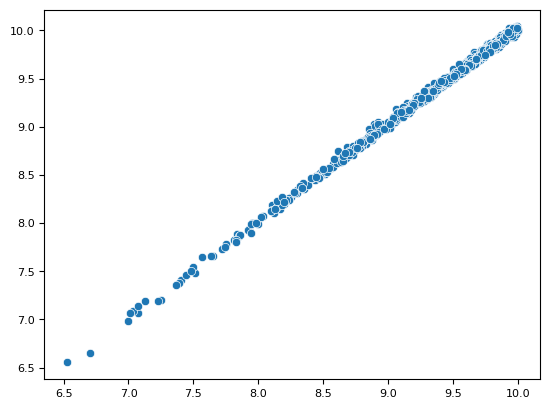

In [9]:
sns.scatterplot(x=y_test.ravel(), y=preds.ravel())

In [10]:
# Test with sample sequence
prediction_arr, attention_weights_arr = [], []
for i in range(12):
    prediction, attention_weights = visualization_model.predict(X_test[i])
    prediction_arr.append(prediction)
    attention_weights_arr.append(attention_weights)
# prediction, attention_weights = visualization_model.predict(X_test[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/home/vojte/.virtualenvs/hluboke-uceni/lib/python3.12/site-packages/keras/src/ops/nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (15, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


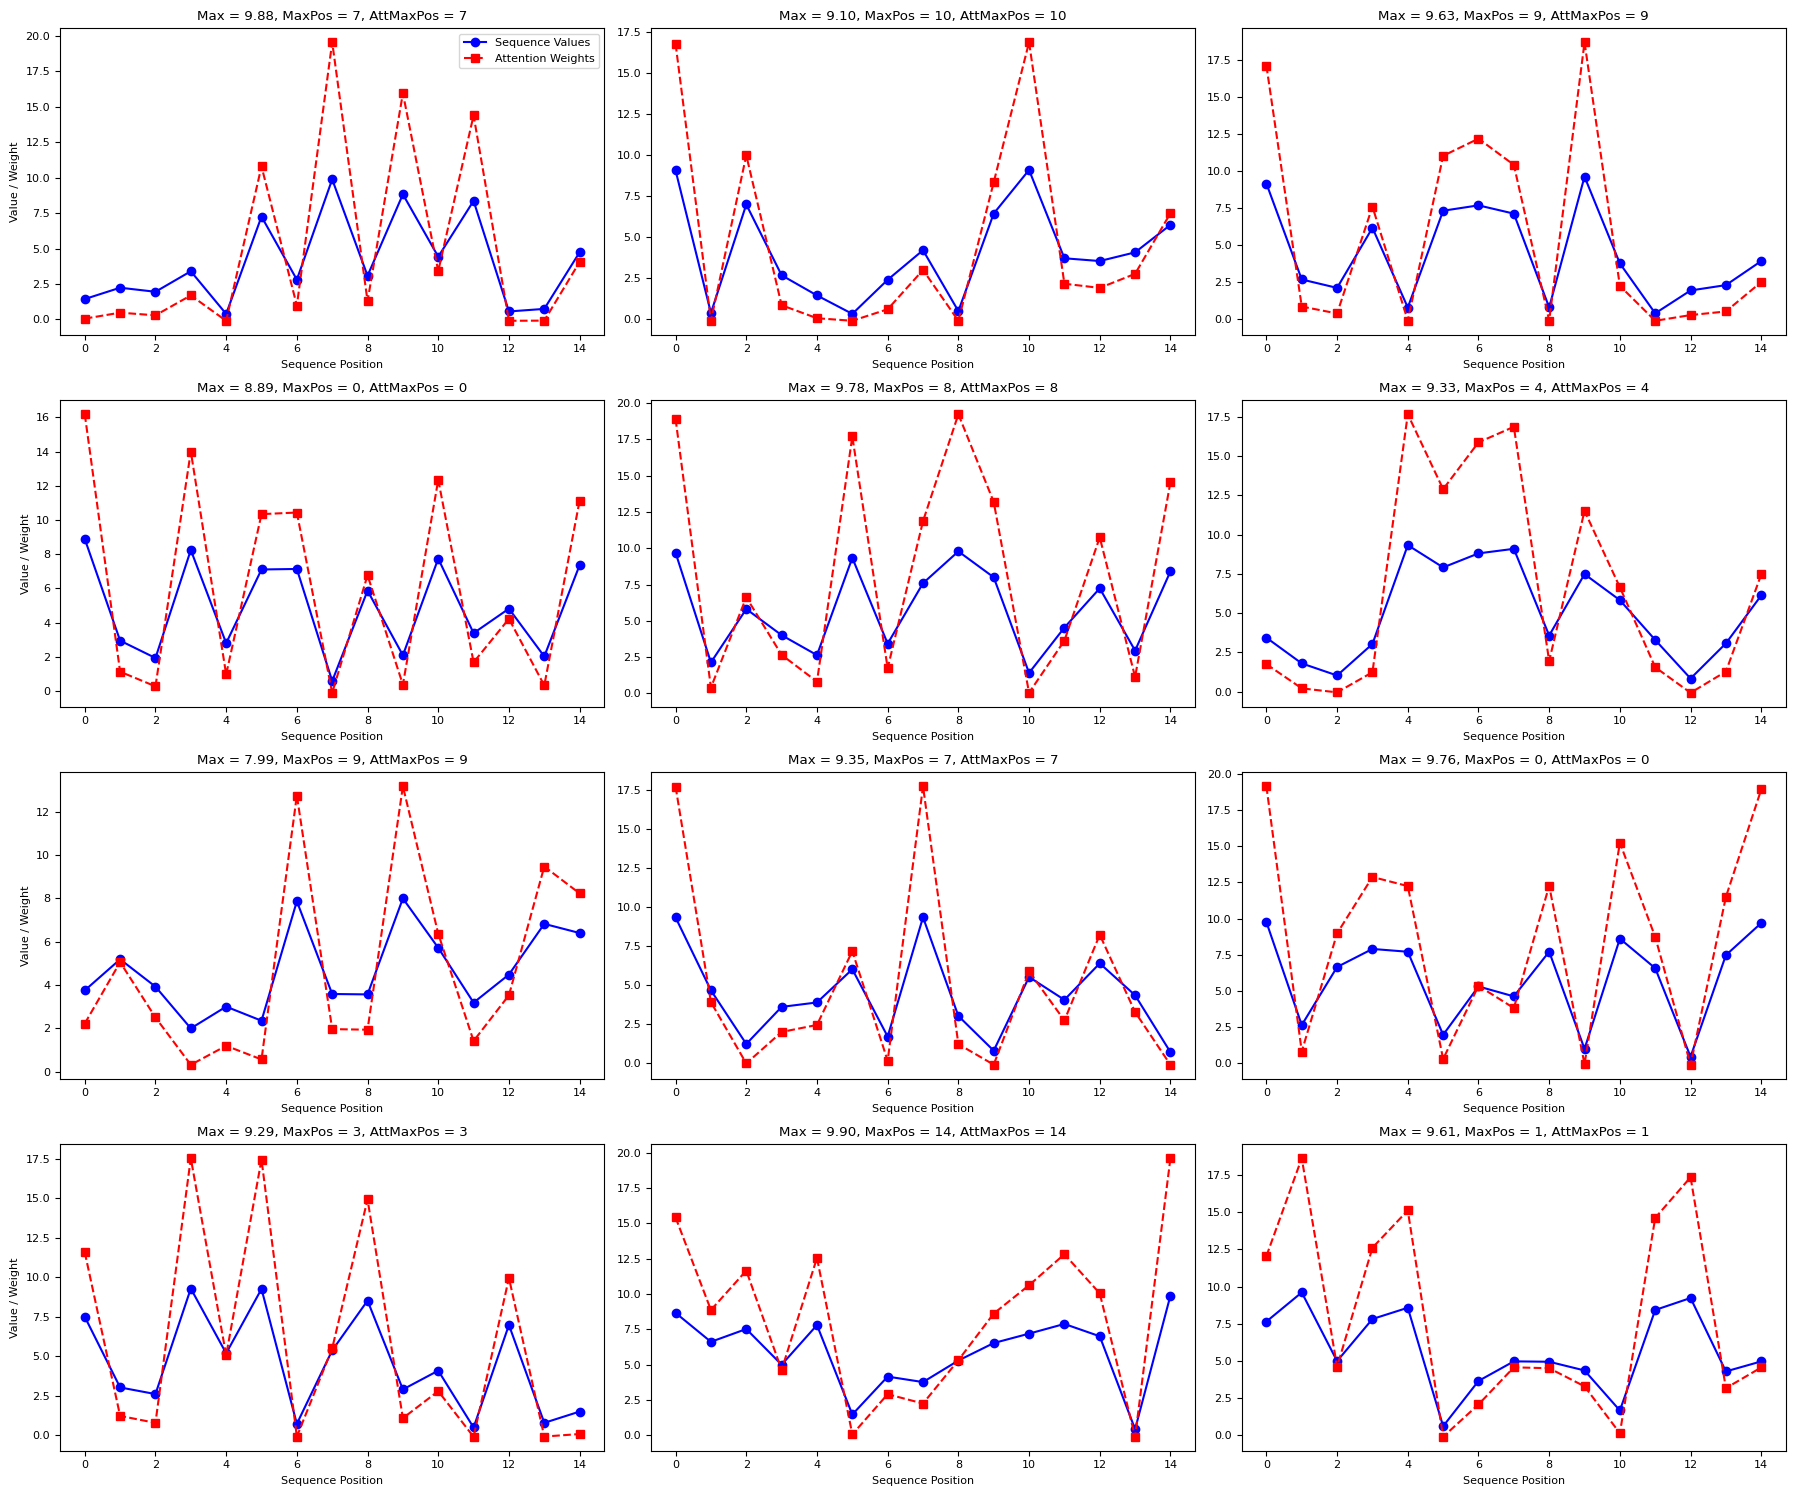

In [11]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 15))
gs = gridspec.GridSpec(4, 3)

for i in range(12):
    ax = plt.subplot(gs[i // 3, i % 3])
    ax.plot(X_test[i], 'b-o', label='Sequence Values')
    ax.plot(attention_weights_arr[i], 'r--s', label='Attention Weights')
    ax.set_title(
        f'Max = {
            y_test[i][0]:.2f}, MaxPos = {
            np.argmax(
                X_test[i])}, AttMaxPos = {
                    np.argmax(
                        attention_weights_arr[i])}')
    ax.set_xlabel('Sequence Position')
    if i % 3 == 0:
        ax.set_ylabel('Value / Weight')
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## ⚡ Now as we know how the Attention layer works we can employ it for the sentiment analysis task

- We will use Yelp dataset which contains reviews of restaurants with either positive (1) or negative (0) labels
  assigned


## Download and load the dataset


In [12]:
path_to_file = tf.keras.utils.get_file(
    'yelp_labelled.txt',
    'https://raw.githubusercontent.com/rasvob/VSB-FEI-Deep-Learning-Exercises/main/datasets/yelp_labelled.txt')

In [13]:
path_to_file

'/home/vojte/.keras/datasets/yelp_labelled.txt'

In [14]:
with open(path_to_file) as f:
    lines = f.readlines()
    lines = [x.rstrip() for x in lines]

In [15]:
len(lines)

3000

In [16]:
lines_dict = [{'Text': x[:-1].rstrip(), 'Label': int(x[-1])} for x in lines]

In [17]:
df = pd.DataFrame.from_dict(lines_dict)

In [18]:
df.head()

,Text,Label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### ⚡ We will use TextVectorization layer as usuall and we will create baseline model without the Attention layer first


In [19]:
embedding_dim = 64  # Dimension of embedded representation - this is already part of latent space, there is captured some dependecy among words, we are learning this vectors in ANN
max_tokens = 3000
sequence_length = 32  # Output dimension after vectorizing - words in vectorited representation are independent

vect_layer = TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Text.values)

In [20]:
vocab = vect_layer.get_vocabulary()

## The dataset is balanced

- 💡 We will use `stratify` parameter of the `train_test_split` to make sure that it stays balanced


In [21]:
df.Label.value_counts()

Label
1    1500
0    1500
Name: count, dtype: int64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    df.Text, df.Label, test_size=0.20, random_state=13, stratify=df.Label)

In [23]:
print(X_train.shape, X_test.shape)

(2400,) (600,)


In [24]:
print('Train')
print(y_train.value_counts())
print('Test')
print(y_test.value_counts())

Train
Label
0    1200
1    1200
Name: count, dtype: int64
Test
Label
0    300
1    300
Name: count, dtype: int64


## Let's define very simple model first

This LSTM layer processes sequential data from the preceding embedding layer (`emb`), generates a 50-dimensional output
vector, and applies two types of dropout regularization to combat overfitting

### Key Components of LSTM

1. **Units (50)**

   - The LSTM layer contains 50 memory cells, each capable of learning long-term dependencies in sequential data
   - The final output (`x`) is a 50-dimensional vector summarizing the sequence’s contextual information

2. **Dropout (0.3)**

   - **Input Dropout**: Randomly drops 30% of input units during training to prevent overfitting
   - Example: If the embedding layer outputs 300-dimensional vectors, 90 features (30% of 300) are masked in each
     training step

3. **Recurrent Dropout (0.4)**
   - Drops 40% of the recurrent connections (hidden state transitions between timesteps) during training
   - This specifically regularizes the LSTM’s internal memory mechanisms


In [25]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(
    len(vocab),
    output_dim=embedding_dim,
    embeddings_regularizer=keras.regularizers.l2(.001))(x_v)
x = LSTM(50, dropout=0.3, recurrent_dropout=0.4)(emb)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(
    optimizer=keras.optimizers.AdamW(),
    loss=keras.losses.BinaryCrossentropy(
        from_logits=False),
    metrics=[
            keras.metrics.BinaryAccuracy()])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 32)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 32, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,051 (840.04 KB)

 Trainable params: 215,051 (840.04 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 253ms/step - binary_accuracy: 0.4763 - loss: 0.8240 - val_binary_accuracy: 0.5042 - val_loss: 0.7517
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - binary_accuracy: 0.4889 - loss: 0.7388 - val_binary_accuracy: 0.5375 - val_loss: 0.7094
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - binary_accuracy: 0.5394 - loss: 0.7045 - val_binary_accuracy: 0.5083 - val_loss: 0.6964
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - binary_accuracy: 0.4878 - loss: 0.6960 - val_binary_accuracy: 0.4938 - val_loss: 0.6939
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - binary_accuracy: 0.5030 - loss: 0.6934 - val_binary_accuracy: 0.4958 - val_loss: 0.6937
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - binary_accuracy: 0.5188 - loss: 0.6933 - val_binary_accuracy: 0.5667 - val_loss: 0.6931
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - binary_accuracy: 0.5630 - loss: 0.6862 - val_binary_accuracy: 0.5437 - val_loss: 0.6823
Epoch 

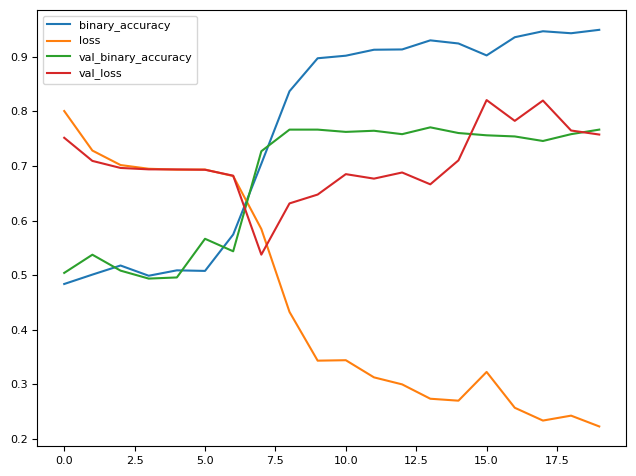

In [27]:
batch_size = 128
epochs = 20

history = model.fit(X_train.values, y_train.values, validation_split=0.2, callbacks=[
                    model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [28]:
test_loss, test_acc = model.evaluate(X_test.values, y_test.values)
test_acc

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - binary_accuracy: 0.7613 - loss: 0.7659


0.7649999856948853

# Now we will create our own Attention layer and add it to the model


![meme01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_08_meme_01.jpg?raw=true)


In [29]:
class MyAttention(Layer):
    def __init__(self, **kwargs):
        super(MyAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(MyAttention, self).build(input_shape)

    def call(self, x):
        dot = tf.matmul(x, self.W) + self.b
        th = tf.math.tanh(dot)
        et = tf.squeeze(th, axis=-1)  # Remove last dimension, similar to np.squeeze
        at = tf.nn.softmax(et)
        at = tf.expand_dims(at, axis=-1)  # Add last dimension, similar to np.expand_dims
        output = x * at
        res = tf.reduce_sum(output, axis=1)  # Sum along the sequence length
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super(MyAttention, self).get_config()

## 💡 The shapes for our layer will look like this:

- input (None, 32, 128) W: (128, 1) b: (32, 1)
- dot (None, 32, 1)
- th (None, 32, 1)
- squeeze (None, 32)
- softmax (None, 32)
- expand_dims (None, 32, 1)
- output (None, 32, 128)
- res (None, 128)

### 🔎 Why do we have `32` biases and `128` weights?


In [30]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(
    len(vocab),
    output_dim=embedding_dim,
    embeddings_regularizer=keras.regularizers.l2(.001))(x_v)
x = LSTM(128, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(emb)
x = MyAttention()(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(
    optimizer=keras.optimizers.AdamW(),
    loss=keras.losses.BinaryCrossentropy(
        from_logits=False),
    metrics=[
            keras.metrics.BinaryAccuracy()])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 32)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 32, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_attention (MyAttention)      │ (None, 128)            │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,105 (1.11 MB)

 Trainable params: 291,105 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 215ms/step - binary_accuracy: 0.5054 - loss: 0.7741 - val_binary_accuracy: 0.4958 - val_loss: 0.6950
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 219ms/step - binary_accuracy: 0.5349 - loss: 0.6876 - val_binary_accuracy: 0.7063 - val_loss: 0.5921
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - binary_accuracy: 0.7811 - loss: 0.4945 - val_binary_accuracy: 0.7458 - val_loss: 0.5964
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 224ms/step - binary_accuracy: 0.8924 - loss: 0.3472 - val_binary_accuracy: 0.7500 - val_loss: 0.6290
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 216ms/step - binary_accuracy: 0.9348 - loss: 0.2438 - val_binary_accuracy: 0.7542 - val_loss: 0.7946
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 255ms/step - binary_accuracy: 0.9417 - loss: 0.2145 - val_binary_accuracy: 0.7583 - val_loss: 0.7871
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - binary_accuracy: 0.9515 - loss: 0.1954 - val_binary_accuracy: 0.7521 - val_loss: 0.7930

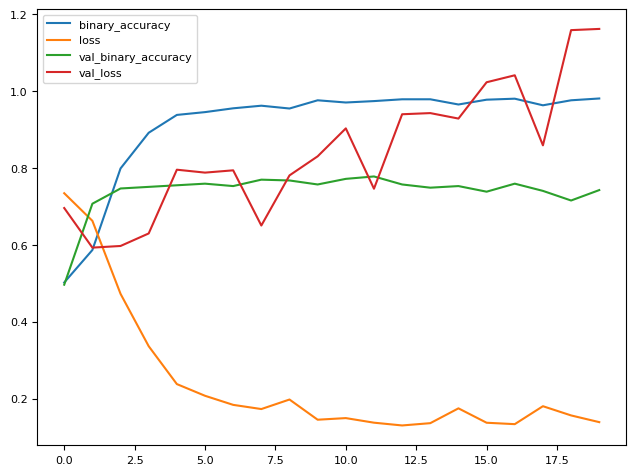

In [32]:
batch_size = 32
epochs = 20

start_time = time.time()
history = model.fit(X_train.values, y_train.values, validation_split=0.2, callbacks=[
                    model_checkpoint_callback], epochs=epochs, batch_size=batch_size)
non_bidirectional_time = time.time() - start_time

show_history(history)

In [33]:
test_loss, test_acc = model.evaluate(X_test.values, y_test.values)
test_acc

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - binary_accuracy: 0.7604 - loss: 1.0708


0.7766666412353516

# ✅ Tasks for the lecture (2p)

- `Attention` layer from the [library](https://github.com/philipperemy/keras-attention) has 2 `score` variants (1p)

  - Use the layer in your model and test both `score` variants
  - Is there any difference in the performance?

- It is possible to make LSTM/GRU layers `Bidirectional` using the
  [Bidirectional layer ](https://keras.io/api/layers/recurrent_layers/bidirectional/) (1p) \* Use it in your model -
  what happened to the number of weights? Was there any improvement?


## Task 1


In [34]:
import attention

### Luong


In [35]:
inputs = Input(shape=(1,), dtype=tf_string)  # Note: shape needs to match original model
x_v = vect_layer(inputs)
emb = keras.layers.Embedding(
    len(vocab),
    output_dim=embedding_dim,
    embeddings_regularizer=keras.regularizers.l2(.001))(x_v)
x = LSTM(128, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(emb)
x = attention.Attention(score='luong')(x)
outputs = keras.layers.Dense(1, 'sigmoid')(x)
model_luong = keras.Model(inputs, outputs)
model_luong.compile(optimizer=keras.optimizers.AdamW(),
                    loss=keras.losses.BinaryCrossentropy(from_logits=False),
                    metrics=[keras.metrics.BinaryAccuracy()])

print("Model with 'luong' score attention:")
model_luong.summary()

Model with 'luong' score attention:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization  │ (None, 32)        │          0 │ input_layer_3[0]… │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 32, 64)    │    192,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32, 128)   │     98,816 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ last_hidden_state   │ (None, 128)       │          0 │ lstm_3[0][0]      │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ luong_w (Dense)     │ (None, 32, 128)   │     16,384 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_score     │ (None, 32)        │          0 │ last_hidden_stat… │
│ (Dot)               │                   │            │ luong_w[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 32)        │          0 │ attention_score[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_vector      │ (None, 128)       │          0 │ lstm_3[0][0],     │
│ (Dot)               │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_output    │ (None, 256)       │          0 │ context_vector[0… │
│ (Concatenate)       │                   │            │ last_hidden_stat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_vector    │ (None, 128)       │     32,768 │ attention_output… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ attention_vector… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 340,097 (1.30 MB)

 Trainable params: 340,097 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
start_time = time.time()
history_luong = model_luong.fit(X_train.values, y_train.values,
                                validation_split=0.2,
                                epochs=20,
                                batch_size=32)
luong_time = time.time() - start_time

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - binary_accuracy: 0.5211 - loss: 0.7748 - val_binary_accuracy: 0.4958 - val_loss: 0.6914
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 240ms/step - binary_accuracy: 0.6258 - loss: 0.6536 - val_binary_accuracy: 0.7437 - val_loss: 0.5261
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - binary_accuracy: 0.8433 - loss: 0.4114 - val_binary_accuracy: 0.7729 - val_loss: 0.5142
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 241ms/step - binary_accuracy: 0.9112 - loss: 0.2820 - val_binary_accuracy: 0.7729 - val_loss: 0.6108
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 236ms/step - binary_accuracy: 0.9466 - loss: 0.2094 - val_binary_accuracy: 0.7812 - val_loss: 0.6600
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 258ms/step - binary_accuracy: 0.9556 - loss: 0.1755 - val_binary_accuracy: 0.7708 - val_loss: 0.7391
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 279ms/step - binary_accuracy: 0.9504 - loss: 0.1708 - val_binary_accuracy: 0.7812 - val_loss: 0.9167

In [37]:
test_loss_luong, test_acc_luong = model_luong.evaluate(X_test.values, y_test.values)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - binary_accuracy: 0.7608 - loss: 1.4233


### Bahdanau


In [38]:
class BahdanauAttention(keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)

    def call(self, values):
        # values: (batch_size, time_steps, hidden_size)
        query = values[:, -1:, :]  # Take last LSTM output (shape: (batch_size, 1, hidden_size))

        score = self.V(tf.nn.tanh(self.W1(query) + self.W2(values)))  # (batch_size, time_steps, 1)
        attention_weights = tf.nn.softmax(score, axis=1)  # (batch_size, time_steps, 1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, hidden_size)

        return context_vector

In [39]:
inputs = Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(inputs)
emb = keras.layers.Embedding(
    len(vocab),
    output_dim=embedding_dim,
    embeddings_regularizer=keras.regularizers.l2(.001))(x_v)
lstm_outputs = LSTM(128, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(emb)

attention_layer = BahdanauAttention(units=128)
x = attention_layer(lstm_outputs)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model_bahdanau = keras.Model(inputs, outputs)
model_bahdanau.compile(optimizer=keras.optimizers.AdamW(),
                       loss=keras.losses.BinaryCrossentropy(from_logits=False),
                       metrics=[keras.metrics.BinaryAccuracy()])

print("Model with 'bahdanau' score attention:")
model_bahdanau.summary()

Model with 'bahdanau' score attention:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 32)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 32, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bahdanau_attention              │ (None, 128)            │        33,153 │
│ (BahdanauAttention)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 324,098 (1.24 MB)

 Trainable params: 324,098 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
start_time = time.time()
history_bahdanau = model_bahdanau.fit(X_train.values, y_train.values,
                                      validation_split=0.2,
                                      epochs=epochs,
                                      batch_size=batch_size)
bahdanau_time = time.time() - start_time

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - binary_accuracy: 0.5095 - loss: 0.7738 - val_binary_accuracy: 0.4958 - val_loss: 0.6948
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 244ms/step - binary_accuracy: 0.5232 - loss: 0.6932 - val_binary_accuracy: 0.6292 - val_loss: 0.6825
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - binary_accuracy: 0.7156 - loss: 0.6141 - val_binary_accuracy: 0.7292 - val_loss: 0.6208
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 235ms/step - binary_accuracy: 0.8451 - loss: 0.4309 - val_binary_accuracy: 0.7271 - val_loss: 0.7254
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 272ms/step - binary_accuracy: 0.9066 - loss: 0.3136 - val_binary_accuracy: 0.7667 - val_loss: 0.6275
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - binary_accuracy: 0.9265 - loss: 0.2629 - val_binary_accuracy: 0.7563 - val_loss: 0.6977
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 260ms/step - binary_accuracy: 0.9427 - loss: 0.2155 - val_binary_accuracy: 0.7542 - val_loss: 0.6090

In [41]:
test_loss_bahdanau, test_acc_bahdanau = model_bahdanau.evaluate(X_test.values, y_test.values)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - binary_accuracy: 0.7742 - loss: 0.8214


### Results


In [42]:
print(f"Test Accuracy ('Luong' score): {test_acc_luong:.4f}")
print(f"Test Accuracy ('Bahdanau' score): {test_acc_bahdanau:.4f}\n")

print(f"Luong attention training time: {luong_time:.2f} seconds")
print(f"Bahdanau attention training time: {bahdanau_time:.2f} seconds")

Test Accuracy ('Luong' score): 0.7783
Test Accuracy ('Bahdanau' score): 0.7883

Luong attention training time: 327.49 seconds
Bahdanau attention training time: 327.47 seconds


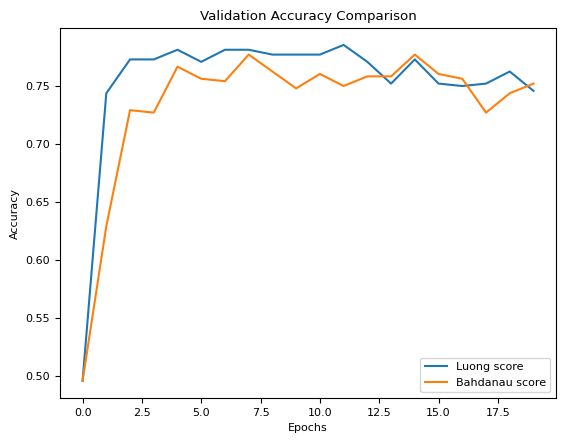

In [43]:
plt.figure()
plt.plot(history_luong.history['val_binary_accuracy'], label='Luong score')
plt.plot(history_bahdanau.history['val_binary_accuracy'], label='Bahdanau score')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Summary

Key Findings:

- **Bahdanau** _(0.7883)_ slightly outperformed **Luong** _(0.7783)_ by **1.28%**.
- Both achieved _solid_ accuracy, with Bahdanau showing a slight edge in this run.
- Training times were nearly identical: **Luong** _(327.49s)_ vs **Bahdanau** _(327.47s)_.

Why the Difference?

- **Bahdanau** _(Additive)_ 🧮: Uses a feed-forward net for attention scores; potentially better at capturing complex word relationships.
- **Luong** _(Multiplicative)_ 🔢: Uses dot-product scoring; often faster but might be slightly less expressive in some cases.


## Task 2


### Bidirectional LSTM


In [44]:
inputs = Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(inputs)
emb = keras.layers.Embedding(
    len(vocab),
    output_dim=embedding_dim,
    embeddings_regularizer=keras.regularizers.l2(.001))(x_v)
x = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.2, return_sequences=True))(emb)
x = MyAttention()(x)
outputs = keras.layers.Dense(1, 'sigmoid')(x)

bidirectional_model = keras.Model(inputs, outputs)
bidirectional_model.compile(optimizer=keras.optimizers.AdamW(),
                            loss=keras.losses.BinaryCrossentropy(from_logits=False),
                            metrics=[keras.metrics.BinaryAccuracy()])

print("Model with Bidirectional LSTM:")
bidirectional_model.summary()

Model with Bidirectional LSTM:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 32)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 32, 64)         │       192,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_attention_1 (MyAttention)    │ (None, 256)            │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,177 (1.49 MB)

 Trainable params: 390,177 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
start_time = time.time()
history_bidirectional = bidirectional_model.fit(X_train.values, y_train.values,
                                                validation_split=0.2,
                                                epochs=epochs,
                                                batch_size=batch_size)
bidirectional_time = time.time() - start_time

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 513ms/step - binary_accuracy: 0.5048 - loss: 0.7746 - val_binary_accuracy: 0.4958 - val_loss: 0.6960
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 524ms/step - binary_accuracy: 0.5385 - loss: 0.6822 - val_binary_accuracy: 0.7104 - val_loss: 0.5772
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 515ms/step - binary_accuracy: 0.7748 - loss: 0.5042 - val_binary_accuracy: 0.7479 - val_loss: 0.5323
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 519ms/step - binary_accuracy: 0.8792 - loss: 0.3397 - val_binary_accuracy: 0.7312 - val_loss: 0.7207
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 494ms/step - binary_accuracy: 0.9179 - loss: 0.2568 - val_binary_accuracy: 0.7500 - val_loss: 0.8893
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 508ms/step - binary_accuracy: 0.9352 - loss: 0.2364 - val_binary_accuracy: 0.7458 - val_loss: 0.9478
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 507ms/step - binary_accuracy: 0.9342 - loss: 0.2332 - val_binary_accuracy: 0.7542 - val_loss: 0.7487

In [46]:
test_loss_bidirectional, test_acc_bidirectional = bidirectional_model.evaluate(X_test.values, y_test.values)
print(f"Test Accuracy (Bidirectional LSTM): {test_acc_bidirectional:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - binary_accuracy: 0.7945 - loss: 0.8381
Test Accuracy (Bidirectional LSTM): 0.7933


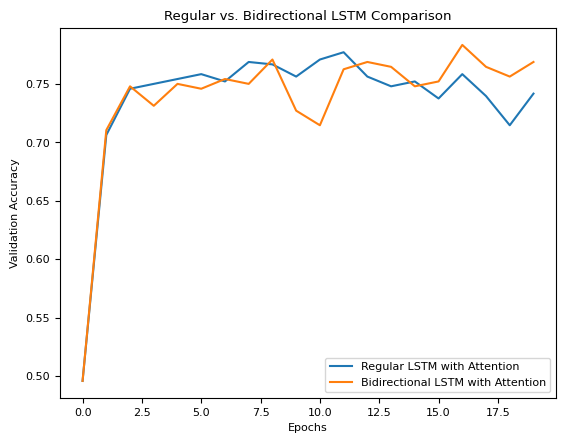

In [47]:
plt.figure()
plt.plot(history.history['val_binary_accuracy'], label='Regular LSTM with Attention')
plt.plot(history_bidirectional.history['val_binary_accuracy'], label='Bidirectional LSTM with Attention')
plt.title('Regular vs. Bidirectional LSTM Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

### Analysis of the models


In [48]:
print("\nModel Comparison Results:")
print(f"Regular LSTM Test Accuracy: {test_acc:.4f}")
print(f"Bidirectional LSTM Test Accuracy: {test_acc_bidirectional:.4f}")
print(f"Improvement: {(test_acc_bidirectional - test_acc) * 100:.2f}%\n")

print(f"Regular LSTM training time: {non_bidirectional_time:.2f} seconds")
print(f"Bidirectional LSTM training time: {bidirectional_time:.2f} seconds\n")

time_ratio = bidirectional_time / non_bidirectional_time

print(f"Time taken for training Regular LSTM: 4:59:58")
print(f"Time taken for training Bidirectional LSTM: 10:35:01")
print(f"Time ratio: Bidirectional takes {time_ratio:.2f}x longer than Regular LSTM")


Model Comparison Results:
Regular LSTM Test Accuracy: 0.7767
Bidirectional LSTM Test Accuracy: 0.7933
Improvement: 1.67%

Regular LSTM training time: 295.86 seconds
Bidirectional LSTM training time: 623.05 seconds

Time taken for training Regular LSTM: 4:59:58
Time taken for training Bidirectional LSTM: 10:35:01
Time ratio: Bidirectional takes 2.11x longer than Regular LSTM


In [49]:
regular_params = model.count_params()
bidirectional_params = bidirectional_model.count_params()
print(f"\nParameter Analysis:")
print(f"Regular LSTM parameter count: {regular_params:,}")
print(f"Bidirectional LSTM parameter count: {bidirectional_params:,}")
print(f"Increase in parameters: {(bidirectional_params - regular_params):,} ({(bidirectional_params / regular_params - 1) * 100:.2f}%)")


Parameter Analysis:
Regular LSTM parameter count: 291,105
Bidirectional LSTM parameter count: 390,177
Increase in parameters: 99,072 (34.03%)


### Why Bidirectional LSTM has more parameters:

A Bidirectional LSTM processes input sequences in both forward and backward directions, effectively doubling the number
of LSTM units:

- **Regular LSTM**: 128 units in one direction = 291,105 parameters
- **Bidirectional LSTM**: 128 × 2 directions = 256 total units = 390,177 parameters

This nearly doubles the parameter count (+99,072 or +34.03%) while providing the following benefits:

- Captures context from both past and future time steps ⬅️➡️
- Provides richer representations that understand complete contextual information 🧠
- Increases model accuracy by 1.67% (from 77.67% to 79.33%) 📈
